In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns


matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] =False


from sklearn.preprocessing import StandardScaler # Scale 변환 -> 표준화 회귀계수 산출
from sklearn.model_selection import train_test_split

import copy
import missingno as msno
import datetime as dt
from dateutil.parser import parse

from tqdm import tqdm

In [172]:
path = './데이터/Sales_final.csv'
df_sales = pd.read_csv(path, encoding='utf-8', index_col = 0)

path = './데이터/Member_final.csv'
df_members = pd.read_csv(path, encoding='utf-8')

path = './데이터/Product_final.csv'
df_products = pd.read_csv(path, encoding='utf-8', index_col = 0)

C:\Users\insea\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\insea\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [185]:
df_sales = pd.merge(df_sales, df_products[['상품명', '물품중분류']], on='상품명', how='left')
df_sales.head(2)

,주문번호,구매일,배송시작일,배송완료일,구매시월령(수정),고객번호,구매금액,결제금액,물품대분류,상품명,배송리드타임,구매일_연도,구매일_월,구매일_일,구매일_요일,할인금액,물품중분류
0,201905052342970,2019-05-06,2019-05-07,2019-05-11,4.0,201812310749735,25800,16314,더블하트,더블하트 SofTouch 모유실감 젖꼭지 M (2입),5,2019,5,6,Monday,9486,수유용품
1,202002203424450,2020-02-20,2020-02-21,2020-02-23,14.0,201812310749735,51200,37769,팬티,NEW 하기스 맥스드라이 팬티 5단계 남아 80매(팬티형),3,2020,2,20,Thursday,13431,기저귀


In [12]:
repurchase_dic = {}

# repurchase_dic = {고객: {상품: 상품 재구매 횟수, ... }, ...}
for idx, sale in tqdm(df_sales.iterrows()):
    # dict에 고객번호 추가
    if sale['고객번호'] not in repurchase_dic:
        repurchase_dic[sale['고객번호']] = {}
    # dict에 상품 및 상품 개수 추가
    if sale['물품중분류'] not in repurchase_dic[sale['고객번호']]:
        repurchase_dic[sale['고객번호']][sale['물품중분류']] = 1
    else: repurchase_dic[sale['고객번호']][sale['물품중분류']] += 1  
        

210039it [00:28, 7417.38it/s]


In [14]:
repurchase_dic

{201812310749735: {'수유용품': 1, '기저귀': 1},
 201812310749770: {'휴지/티슈': 1},
 201812310749771: {'기저귀': 2},
 201812310749774: {'기저귀': 2},
 201812310749780: {'기저귀': 1},
 201812310749783: {'산모전용제품': 1, '수유용품': 3, '기저귀': 4},
 201812310749784: {'기저귀': 6, '의류/잡화': 2},
 201812310749787: {'기저귀': 11,
  '위생용품/워시': 2,
  '이유용품': 1,
  '수유용품': 1,
  '위생용품/세제': 1,
  '청소용품': 1},
 201812310749792: {'수유용품': 2, '기저귀': 3},
 201812310749802: {'수유용품': 1},
 201812310749811: {'수유용품': 1},
 201812310749816: {'수유용품': 2},
 201812310749817: {'물티슈': 1, '휴지/티슈': 1, '생리대': 2},
 201812310749818: {'기저귀': 1},
 201812310749820: {'기저귀': 5},
 201812310749821: {'수유용품': 1, '기저귀': 3},
 201812310749826: {'수유용품': 3},
 201812310749827: {'기저귀': 5, '수유용품': 1},
 201812310749828: {'기저귀': 1},
 201812310749831: {'휴지/티슈': 2, '수유용품': 1},
 201812310749833: {'기저귀': 1},
 201812310749839: {'수유용품': 1, '기저귀': 4, '휴지/티슈': 1},
 201812310749844: {'수유용품': 1, '위생용품/세제': 1},
 201812310749852: {'수유용품': 2, '기저귀': 5},
 201812310749855: {'키친타올/행주': 1},
 201

In [15]:
repurchase_copy_dic = copy.deepcopy(repurchase_dic)
for custom_key in tqdm(repurchase_copy_dic):
    for product_key in repurchase_copy_dic[custom_key]:
        # 1) 재구매가 없는 경우 삭제
        if repurchase_dic[custom_key][product_key] == 1:
            del(repurchase_dic[custom_key][product_key])
    # 2) 고객이 구매하였지만 재구매하지 않은 상품 삭제
    if len(repurchase_dic[custom_key]) == 0:
        del(repurchase_dic[custom_key])
#repurchase_dic

100%|████████████████████████████████████████████████████████████████████████| 81360/81360 [00:00<00:00, 684454.69it/s]


In [16]:
repurchase_dic

{201812310749771: {'기저귀': 2},
 201812310749774: {'기저귀': 2},
 201812310749783: {'수유용품': 3, '기저귀': 4},
 201812310749784: {'기저귀': 6, '의류/잡화': 2},
 201812310749787: {'기저귀': 11, '위생용품/워시': 2},
 201812310749792: {'수유용품': 2, '기저귀': 3},
 201812310749816: {'수유용품': 2},
 201812310749817: {'생리대': 2},
 201812310749820: {'기저귀': 5},
 201812310749821: {'기저귀': 3},
 201812310749826: {'수유용품': 3},
 201812310749827: {'기저귀': 5},
 201812310749831: {'휴지/티슈': 2},
 201812310749839: {'기저귀': 4},
 201812310749852: {'수유용품': 2, '기저귀': 5},
 201812310749864: {'수유용품': 2},
 201812310749866: {'기저귀': 2},
 201812310749867: {'수유용품': 3},
 201812310749876: {'기저귀': 4},
 201812310749883: {'식품/음료': 2},
 201812310749886: {'수유용품': 2},
 201812310749896: {'기저귀': 4},
 201812310749901: {'기저귀': 4, '물티슈': 2, '수유용품': 2},
 201812310749918: {'생리대': 4, '휴지/티슈': 2},
 201812310749924: {'물티슈': 6, '휴지/티슈': 4, '생리대': 2},
 201812310749927: {'기저귀': 5, '물티슈': 2, '키친타올/행주': 2},
 201812310749934: {'수유용품': 2},
 201812310749946: {'기저귀': 2},
 2018123107

In [27]:
# 날짜 데이터 추가
repurchase_date_dic = copy.deepcopy(repurchase_dic)
for cus_num in repurchase_date_dic:
    for product_name in repurchase_date_dic[cus_num]:
        repurchase_date_dic[cus_num][product_name] = []
      
        
for cus_num in tqdm(repurchase_date_dic):
    for product_name in repurchase_date_dic[cus_num]:
        df_temp = df_sales[df_sales.고객번호 == cus_num]
        df_temp = df_temp[df_temp.물품중분류 == product_name]
        repurchase_date_dic[cus_num][product_name] = list(df_temp['구매일'])
repurchase_date_dic

100%|████████████████████████████████████████████████████████████████████████████| 28442/28442 [08:08<00:00, 58.23it/s]


{201812310749771: {'기저귀': ['2019-05-13', '2019-05-13']},
 201812310749774: {'기저귀': ['2019-05-10', '2019-07-29']},
 201812310749783: {'수유용품': ['2019-06-30', '2019-06-30', '2020-02-10'],
  '기저귀': ['2019-07-23', '2019-08-09', '2020-02-10', '2020-07-11']},
 201812310749784: {'기저귀': ['2019-04-29',
   '2019-06-25',
   '2019-09-28',
   '2020-04-02',
   '2020-04-25',
   '2020-07-23'],
  '의류/잡화': ['2020-01-17', '2020-01-17']},
 201812310749787: {'기저귀': ['2019-01-01',
   '2019-01-21',
   '2019-01-29',
   '2019-02-24',
   '2019-03-15',
   '2019-04-08',
   '2019-04-28',
   '2019-08-10',
   '2019-10-05',
   '2019-11-26',
   '2020-01-23'],
  '위생용품/워시': ['2019-02-12', '2020-04-11']},
 201812310749792: {'수유용품': ['2019-06-18', '2019-09-06'],
  '기저귀': ['2019-08-02', '2019-09-07', '2019-09-07']},
 201812310749816: {'수유용품': ['2019-02-27', '2019-02-27']},
 201812310749817: {'생리대': ['2019-03-31', '2019-10-03']},
 201812310749820: {'기저귀': ['2019-01-01',
   '2019-04-03',
   '2019-05-01',
   '2019-07-22',
   '

In [28]:
def get_elapsed_time(start, end):
    start = parse(start)
    end = parse(end)
    elapsed_time = end-start
    return elapsed_time.days

In [29]:
repurchase_elapsed_time_dic = copy.deepcopy(repurchase_dic)
for cus_num in repurchase_elapsed_time_dic:
    for product_name in repurchase_elapsed_time_dic[cus_num]:
        repurchase_elapsed_time_dic[cus_num][product_name] = []

for cus_num in tqdm(repurchase_elapsed_time_dic):
    for product_name in repurchase_elapsed_time_dic[cus_num]:
        date_list = repurchase_date_dic[cus_num][product_name]
        for date in range(len(date_list)-1):
            repurchase_elapsed_time_dic[cus_num][product_name].append(get_elapsed_time(date_list[date],date_list[date+1])) 
repurchase_elapsed_time_dic

100%|██████████████████████████████████████████████████████████████████████████| 28442/28442 [00:10<00:00, 2789.20it/s]


In [30]:
repurchase_elapsed_time_dic

{201812310749771: {'기저귀': [0]},
 201812310749774: {'기저귀': [80]},
 201812310749783: {'수유용품': [0, 225], '기저귀': [17, 185, 152]},
 201812310749784: {'기저귀': [57, 95, 187, 23, 89], '의류/잡화': [0]},
 201812310749787: {'기저귀': [20, 8, 26, 19, 24, 20, 104, 56, 52, 58],
  '위생용품/워시': [424]},
 201812310749792: {'수유용품': [80], '기저귀': [36, 0]},
 201812310749816: {'수유용품': [0]},
 201812310749817: {'생리대': [186]},
 201812310749820: {'기저귀': [92, 28, 82, 30]},
 201812310749821: {'기저귀': [0, 176]},
 201812310749826: {'수유용품': [27, 37]},
 201812310749827: {'기저귀': [156, 173, 98, 30]},
 201812310749831: {'휴지/티슈': [138]},
 201812310749839: {'기저귀': [0, 15, 93]},
 201812310749852: {'수유용품': [218], '기저귀': [106, 21, 133, 71]},
 201812310749864: {'수유용품': [0]},
 201812310749866: {'기저귀': [39]},
 201812310749867: {'수유용품': [21, 110]},
 201812310749876: {'기저귀': [0, 55, 78]},
 201812310749883: {'식품/음료': [0]},
 201812310749886: {'수유용품': [6]},
 201812310749896: {'기저귀': [16, 78, 76]},
 201812310749901: {'기저귀': [80, 178, 150], '물티슈

In [32]:
repurchase_elapsed_time_dic_temp = copy.deepcopy(repurchase_elapsed_time_dic)
for cus_num in tqdm(repurchase_elapsed_time_dic_temp):
    for product_name in repurchase_elapsed_time_dic_temp[cus_num]:
        while 0 in repurchase_elapsed_time_dic[cus_num][product_name]:
            repurchase_elapsed_time_dic[cus_num][product_name].remove(0)

for cus_num in tqdm(repurchase_elapsed_time_dic_temp):
    for product_name in repurchase_elapsed_time_dic_temp[cus_num]:
        if len(repurchase_elapsed_time_dic[cus_num][product_name])==0:
            del(repurchase_elapsed_time_dic[cus_num][product_name])
    if len(repurchase_elapsed_time_dic[cus_num])==0:
        del(repurchase_elapsed_time_dic[cus_num])
repurchase_elapsed_time_dic

100%|████████████████████████████████████████████████████████████████████████| 28442/28442 [00:00<00:00, 548109.53it/s]


{201812310749774: {'기저귀': [80]},
 201812310749783: {'수유용품': [225], '기저귀': [17, 185, 152]},
 201812310749784: {'기저귀': [57, 95, 187, 23, 89]},
 201812310749787: {'기저귀': [20, 8, 26, 19, 24, 20, 104, 56, 52, 58],
  '위생용품/워시': [424]},
 201812310749792: {'수유용품': [80], '기저귀': [36]},
 201812310749817: {'생리대': [186]},
 201812310749820: {'기저귀': [92, 28, 82, 30]},
 201812310749821: {'기저귀': [176]},
 201812310749826: {'수유용품': [27, 37]},
 201812310749827: {'기저귀': [156, 173, 98, 30]},
 201812310749831: {'휴지/티슈': [138]},
 201812310749839: {'기저귀': [15, 93]},
 201812310749852: {'수유용품': [218], '기저귀': [106, 21, 133, 71]},
 201812310749866: {'기저귀': [39]},
 201812310749867: {'수유용품': [21, 110]},
 201812310749876: {'기저귀': [55, 78]},
 201812310749886: {'수유용품': [6]},
 201812310749896: {'기저귀': [16, 78, 76]},
 201812310749901: {'기저귀': [80, 178, 150], '물티슈': [87], '수유용품': [21]},
 201812310749918: {'생리대': [214, 58], '휴지/티슈': [1]},
 201812310749924: {'물티슈': [58, 248], '휴지/티슈': [292, 153, 64], '생리대': [105]},
 2018123

In [177]:
repurchase_elapsed_time_dic

{201812310749774: {'기저귀': [80]},
 201812310749783: {'수유용품': [225], '기저귀': [17, 185, 152]},
 201812310749784: {'기저귀': [57, 95, 187, 23, 89]},
 201812310749787: {'기저귀': [20, 8, 26, 19, 24, 20, 104, 56, 52, 58],
  '위생용품/워시': [424]},
 201812310749792: {'수유용품': [80], '기저귀': [36]},
 201812310749817: {'생리대': [186]},
 201812310749820: {'기저귀': [92, 28, 82, 30]},
 201812310749821: {'기저귀': [176]},
 201812310749826: {'수유용품': [27, 37]},
 201812310749827: {'기저귀': [156, 173, 98, 30]},
 201812310749831: {'휴지/티슈': [138]},
 201812310749839: {'기저귀': [15, 93]},
 201812310749852: {'수유용품': [218], '기저귀': [106, 21, 133, 71]},
 201812310749866: {'기저귀': [39]},
 201812310749867: {'수유용품': [21, 110]},
 201812310749876: {'기저귀': [55, 78]},
 201812310749886: {'수유용품': [6]},
 201812310749896: {'기저귀': [16, 78, 76]},
 201812310749901: {'기저귀': [80, 178, 150], '물티슈': [87], '수유용품': [21]},
 201812310749918: {'생리대': [214, 58], '휴지/티슈': [1]},
 201812310749924: {'물티슈': [58, 248], '휴지/티슈': [292, 153, 64], '생리대': [105]},
 2018123

In [178]:
diaper = []
lactation_product = []
sanitary_pad = []

for cus_num in tqdm(repurchase_elapsed_time_dic):
    for product_name in repurchase_elapsed_time_dic[cus_num]:
        if product_name == '기저귀': 
            diaper +=repurchase_elapsed_time_dic[cus_num][product_name]
        elif product_name == '수유용품': 
            lactation_product +=repurchase_elapsed_time_dic[cus_num][product_name]
        elif product_name == '생리대': 
            sanitary_pad +=repurchase_elapsed_time_dic[cus_num][product_name]
    

100%|████████████████████████████████████████████████████████████████████████| 22900/22900 [00:00<00:00, 728768.95it/s]


In [195]:
df_diaper = pd.DataFrame({'diaper': diaper})
df_diaper = pd.DataFrame(df_diaper.value_counts('diaper')).reset_index(drop=False).sort_values('diaper')

C:\Users\insea\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


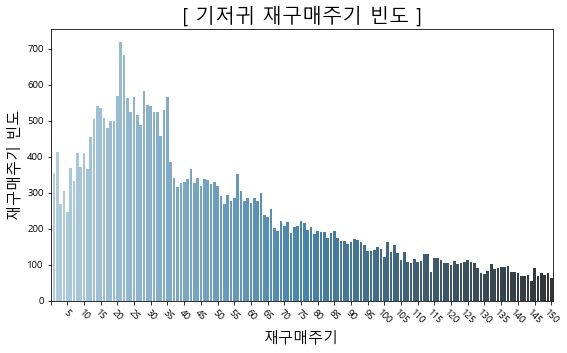

In [232]:
plt.figure(figsize=(9,5))
plt.xticks(rotation=-45)
plt.xlabel('재구매주기', fontsize = 15)
plt.ylabel('재구매주기 빈도', fontsize = 15)
plt.title('[ 기저귀 재구매주기 빈도 ]', fontsize = 20)
end=150
g = sns.barplot(list(df_diaper['diaper'][:end]),list(df_diaper[0])[:end], palette="Blues_d");
g.set_xticks(range(-1, 150, 5));

In [219]:
# plt.figure(figsize=(30,30))
# df_diaper[0].plot.bar();
df_diaper.iloc[:25][0].sum()

11493

In [223]:
p_name = ['기저귀', '수유용품','생리대']
re_cy = [25,10,30]
rep=[0.43706457072254007,0.2684722222222222,0.2460745829244357]
in_rep = [0.11932968550455286, 0.03836805555555556, 0.07809944389924763]
df_re_table = pd.DataFrame({'상품이름': p_name, '구매주기': re_cy, '재구매율': rep, '구매주기 내 재구매율': in_rep})
df_re_table.round(3).to_csv('주요상품재구매주기.csv', encoding='utf-8-sig')

In [203]:
11493/len(df_sales[df_sales.물품중분류 == '기저귀'])

0.11932968550455286

In [214]:
1105/len(df_sales[df_sales.물품중분류 == '수유용품'])

0.03836805555555556

In [217]:
955/len(df_sales[df_sales.물품중분류 == '생리대'])

0.07809944389924763

In [205]:
df_lactation_product = pd.DataFrame({'lactation_product': lactation_product})
df_lactation_product = pd.DataFrame(df_lactation_product.value_counts('lactation_product')).reset_index(drop=False).sort_values('lactation_product')

C:\Users\insea\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


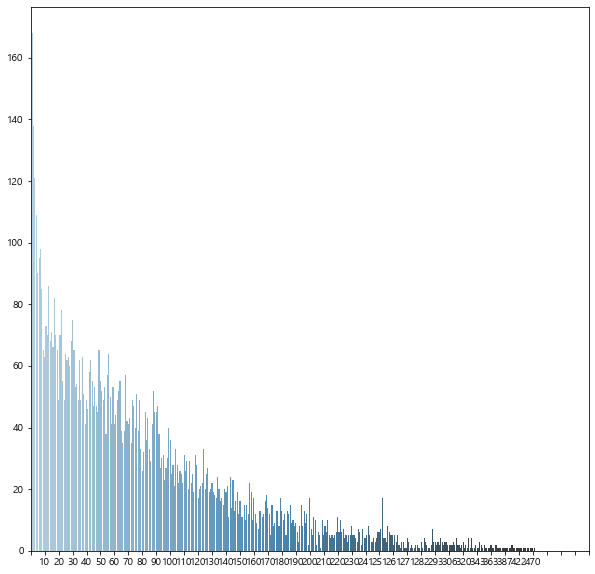

In [208]:
plt.figure(figsize=(10,10))
end = 400
g = sns.barplot(list(df_lactation_product['lactation_product'])[:end],list(df_lactation_product[0])[:end], palette="Blues_d");
g.set_xticks(range(-1, 400, 10));

In [123]:
# plt.figure(figsize=(20,30))
# df_lactation_product[0].plot.bar();

In [215]:
df_sanitary_pad = pd.DataFrame({'sanitary_pad': sanitary_pad})
df_sanitary_pad = pd.DataFrame(df_sanitary_pad.value_counts('sanitary_pad')).reset_index(drop=False).sort_values('sanitary_pad')
g.set_xticks(range(-1, 300, 5));

C:\Users\insea\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


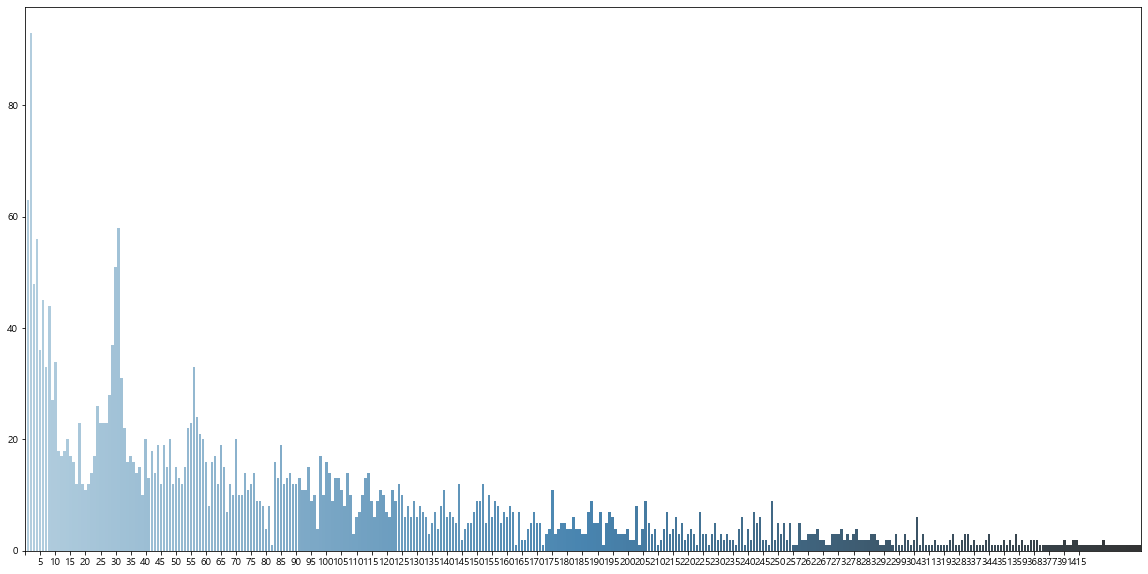

In [141]:
plt.figure(figsize=(20,10))
g = sns.barplot(list(df_sanitary_pad['sanitary_pad']),list(df_sanitary_pad[0]),palette="Blues_d");
g.set_xticks(range(-1, 350, 5));

In [125]:
# plt.figure(figsize=(30,30))
# df_sanitary_pad[0].plot.bar();